In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [7]:
os.chdir('C:/Users/Kiki/Projects/ner_movies/Scripts')

In [8]:
file=pd.read_csv("finalmodel.h5")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [2]:
def read_data():
    os.chdir('D:/TU_Graz/Thesis/Datasets/Reddit_features')
    train = pd.read_csv("train_final_all.csv")
    test = pd.read_csv("test_final_all.csv")
    data = train.append(test)
    
    return train, test, data

In [3]:
def create_lists(data, category):
    words = list(set(data["Token"].values))
    words.append("ENDPAD")
    n_words = len(words)
    tags = list(set(data[category].values))
    n_tags = len(tags)
    
    return words, n_words, tags, n_tags

In [4]:
def group_sentences(data, category):
    all_sents = []
    sent_ids = data['Sent_id'].unique()
    for curr_id in sent_ids:
        tmp_df = data[data['Sent_id'] == curr_id]
        tmp_df = pd.concat([tmp_df['Token'], tmp_df["Token_index"], tmp_df.iloc[:,4:149], tmp_df[category]], axis = 1)
        records = tmp_df.to_records(index=False)
        all_sents.append(records)
    return all_sents

In [5]:
def remove_sents_over_threshold(sents, threshold):
    sentences = list()
    for s in sents:
        if len(s) < threshold:
            sentences.append(s)
    return sentences

In [6]:
def prepare_and_pad(sentences, max_len, word2idx, tag2idx):
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = n_words - 1)

    y = [[tag2idx[w[len(w)-1]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
    y = [to_categorical(i, num_classes=n_tags) for i in y]
    
    return X, y

In [7]:
def build_model(max_len, n_words, n_tags):
    input = Input(shape=(max_len,))
    model = Embedding(input_dim=n_words, output_dim=max_len, input_length=max_len)(input)
    model = Dropout(0.1)(model)
    model = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.3))(model)  # variational biLSTM
    out = Dense(n_tags, activation="softmax")(model) 
    #out = TimeDistributed(Dense(n_tags, activation="softmax"))(model) 
    model = Model(input, out)
    return model 

In [8]:
def plot_learning_curves(hist, curve1, curve2):
    plt.figure(figsize=(6,6))
    plt.plot(hist[curve1])
    plt.plot(hist[curve2])
    plt.show()

In [9]:
def evaluate_test_data(model, X_test, y_test):
    p = model.predict(np.array(X_test))
    p = np.argmax(p, axis=-1)
    y_test = np.array(y_test)
    y_test = np.argmax(y_test, axis=-1)

    y_orig = []
    for sent in y_test:
        for tag in sent:
            y_orig.append(tag)
        
    y_preds = []
    for sent in p:
        for tag in sent:
            y_preds.append(tag)    

    report = classification_report(y_orig, y_preds)
    print(report)

Loading the data...
Creating sets of words and tags...
Creating sentence list...
Removing submissions longer than threshold...
Creating word and tag maps...
Padding data...
Building the model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          2922900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 300)          541200    
_________________________________________________________________
dense_1 (Dense)              (None, 300, 17)           5117      
Total params: 3,469,217
Trainable params: 3,469,217
Non-traina

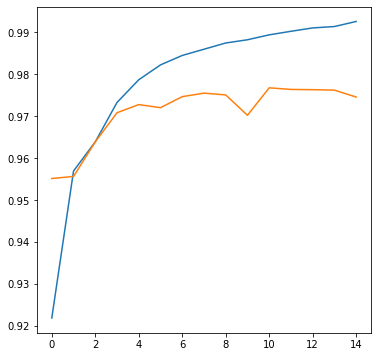

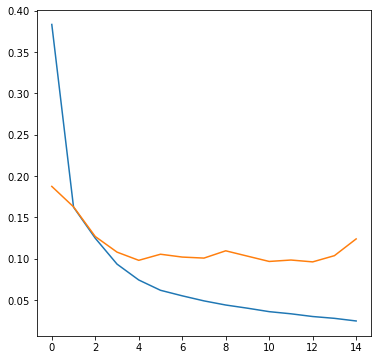

Test the model...
              precision    recall  f1-score   support

           0       0.08      0.09      0.08        33
           1       0.53      0.13      0.21       456
           2       0.00      0.00      0.00        19
           3       0.05      0.12      0.07        56
           4       0.10      0.08      0.09        37
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           8       0.73      0.82      0.77       214
           9       0.00      0.00      0.00        21
          10       0.00      0.00      0.00        32
          11       0.92      0.65      0.76      1814
          12       0.25      0.14      0.18        28
          13       0.60      0.28      0.38       750
          14       0.93      0.87      0.90        46
          15       0.88      0.66      0.76      1409
          16       0.98      1.00      0.99    104277

    accuracy                           0.98    109200
   macro

C:\Users\Kiki\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'X_te' is not defined

In [11]:
print("Loading the data...")
train, test, data = read_data()

print("Creating sets of words and tags...")
words, n_words, tags, n_tags = create_lists(data, "BIO")

print("Creating sentence list...")
sents = group_sentences(data, 'BIO')

print("Removing submissions longer than threshold...")
sentences = remove_sents_over_threshold(sents, 300)

print("Creating word and tag maps...")
max_len = 300
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

print("Padding data...")
X, y = prepare_and_pad(sentences, max_len, word2idx, tag2idx)

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
#X_tr = X[0:1185], y_tr = y[0:1185], X_te = X[1186:], y_te = y[1186:]

print("Building the model...")
model = build_model(max_len, n_words, n_tags)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

print("Fitting the model....")
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=15, validation_split=0.2, verbose=2)
hist = pd.DataFrame(history.history)

print("Plotting learning curves...")
plot_learning_curves(hist, "accuracy", "val_accuracy")
plot_learning_curves(hist, "loss", "val_loss")

print("Test the model...")
evaluate_test_data(model, X_test, y_test) 

print("Output predictions for a random example...")
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_test[i], p[0]):
    if(words[w] != 'ENDPAD'):
        print("{:15}: {}".format(words[w], tags[pred]))

Output predictions for a random example...
Word            (True ): Pred
Feel           : O
-              : O
good           : O
/Comedy        : B-keyword-pos
Independent    : O
Films          : O
Hey            : O
Redditors      : O
!              : O
NEW_LINE       : O
NEW_LINE       : O
I              : O
'              : O
m              : O
looking        : O
to             : O
watch          : O
any            : O
sort           : O
of             : O
comedy         : B-gen-pos
(              : O
dark           : O
,              : O
romantic       : O
,              : O
etc            : O
)              : O
or             : O
feel           : O
-              : O
good           : O
independent    : B-keyword-pos
films          : O
.              : O
Two            : O
movies         : O
that           : O
come           : O
to             : O
mind           : O
that           : O
I              : O
'              : O
ve             : O
already        : O
seen           : O
ar